### Imports

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import umap
from sklearn.preprocessing import PowerTransformer
from tqdm.notebook import tqdm, trange
from sklearn.metrics import davies_bouldin_score
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from prince import FAMD, PCA
from sklearn.preprocessing import StandardScaler
from kmodes.kprototypes import KPrototypes
# import plotly.graph_objects as go
import warnings
warnings.filterwarnings("ignore")


#Our own librabries
import sys
sys.path.insert(1, '../../Environnement/')
from utils import clean_data, add_Loss, regroupe_crop
import clean
import merge



## Import and clean data 

In [2]:
#Select the dataset of one season of one year
YEAR = 2019
SEASON = "Rabi" # or "Kharif" 

#Path to the dataset
pathData_R = f"..\..\Data\RawDataUnified\RawData_{YEAR}_Rabi"
pathData_K= f"..\..\Data\RawDataUnified\RawData_{YEAR}_Kharif"


df_R = pd.read_csv(pathData_R)
df_K = pd.read_csv(pathData_K)

In [3]:
#Clean an add loss to data
df_R=add_Loss(clean_data(df_R))
df_K=add_Loss(clean_data(df_K))

df_R.head()

,Crop,Area Sown (Ha),Area Insured (Ha),SI Per Ha (Inr/Ha),Lp_2011,Lp_2012,Lp_2013,Lp_2014,Lp_2015,Lp_2016,Lp_2017,Loss
key,,,,,,,,,,,,
andhra pradesh_anantapur_vidapanakal___,Bengal Gram (Chana),179.859471,160.816527,30000.0,0.014822,0.0,0.0,0.000000,0.882341,0.645266,0.000000,1.078638e+05
andhra pradesh_anantapur_vajrakarur___,Bengal Gram (Chana),179.859471,160.816527,30000.0,0.000000,0.0,0.0,0.000000,0.217446,0.000000,0.347871,0.000000e+00
andhra pradesh_anantapur_gooty___,Bengal Gram (Chana),179.859471,160.816527,30000.0,0.330642,0.0,0.0,0.086273,0.000000,0.496653,0.122131,1.516659e+06
andhra pradesh_anantapur_guntakal___,Bengal Gram (Chana),179.859471,160.816527,30000.0,0.330642,0.0,0.0,0.086273,0.000000,0.496653,0.122131,1.516659e+06
andhra pradesh_anantapur_pamidi___,Bengal Gram (Chana),179.859471,160.816527,30000.0,0.330642,0.0,0.0,0.086273,0.000000,0.496653,0.122131,1.516659e+06


In [4]:
#NORMALISATION OF DATA (uses : for FAMD and for computing the DB criteria)
data_R=df_R.copy(deep=True)
data_K=df_K.copy(deep=True)
scale = StandardScaler()
data_R.loc[:,data_R.columns !='Crop']=scale.fit_transform(data_R.loc[:,data_R.columns !='Crop'])
data_K.loc[:,data_K.columns !='Crop']=scale.fit_transform(data_K.loc[:,data_K.columns !='Crop'])

#data for Davis_Bouldin criteria 
collumns_db = [f'Lp_{i}' for i in range(2011,2018)]
data_R_db=data_R[collumns_db]
data_K_db=data_K[collumns_db]
data_R_db.head()

,Lp_2011,Lp_2012,Lp_2013,Lp_2014,Lp_2015,Lp_2016,Lp_2017
key,,,,,,,
andhra pradesh_anantapur_vidapanakal___,-0.665553,-0.71241,-0.786921,-0.997198,2.895587,1.590735,-0.451395
andhra pradesh_anantapur_vajrakarur___,-0.744326,-0.71241,-0.786921,-0.997198,0.141328,-0.549593,0.802982
andhra pradesh_anantapur_gooty___,1.012962,-0.71241,-0.786921,-0.675410,-0.759418,1.097792,-0.011006
andhra pradesh_anantapur_guntakal___,1.012962,-0.71241,-0.786921,-0.675410,-0.759418,1.097792,-0.011006
andhra pradesh_anantapur_pamidi___,1.012962,-0.71241,-0.786921,-0.675410,-0.759418,1.097792,-0.011006


## K-means (with only the Lp data)

In [5]:
# reducer_R = umap.UMAP(metric='l2')
# embedding_R = reducer_R.fit_transform(data_R_db)

  0%|          | 0/14 [00:00<?, ?it/s]

db index for Rabi with k = 2 :  1.1449840670484963
db index for Rabi with k = 3 :  0.8789463131715455
db index for Rabi with k = 4 :  1.2566712101868416
db index for Rabi with k = 5 :  1.2782729113839544
db index for Rabi with k = 6 :  1.379573183155804
db index for Rabi with k = 7 :  1.2816571762436146
db index for Rabi with k = 8 :  1.3040776072129343
db index for Rabi with k = 9 :  1.2796085515533915
db index for Rabi with k = 10 :  1.2737969396311546
db index for Rabi with k = 11 :  1.2576176911273944
db index for Rabi with k = 12 :  1.2278183969366767
db index for Rabi with k = 13 :  1.1983144566216297
db index for Rabi with k = 14 :  1.212174549912619
db index for Rabi with k = 15 :  1.2403679375261845


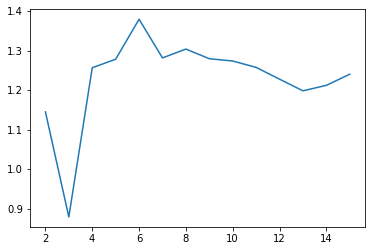

In [ ]:
Db_R=[]
for i in trange(2,16) :
    nb_clusters = i
    kmeans_R = KMeans(init="k-means++", n_clusters=nb_clusters, max_iter=500, random_state=45).fit(data_R_db)
    kmeans_labels_R = kmeans_R.labels_
    db_index = davies_bouldin_score(data_R_db, kmeans_labels_R)
    Db_R.append(db_index)
    print(f"db index for Rabi with k = {nb_clusters} : ", db_index)
plt.plot(np.arange(2,16), Db_R)

  0%|          | 0/14 [00:00<?, ?it/s]

db index for Rabi with k = 2 :  1.4655587671808596
db index for Rabi with k = 3 :  1.2857888734877883
db index for Rabi with k = 4 :  1.4850622060802277
db index for Rabi with k = 5 :  1.4254887469403474
db index for Rabi with k = 6 :  1.426480270730597
db index for Rabi with k = 7 :  1.3718302945675784
db index for Rabi with k = 8 :  1.3505520872125294
db index for Rabi with k = 9 :  1.3498275263769122
db index for Rabi with k = 10 :  1.333617605398617
db index for Rabi with k = 11 :  1.2951664133413117
db index for Rabi with k = 12 :  1.29875386261543
db index for Rabi with k = 13 :  1.2396080143365629
db index for Rabi with k = 14 :  1.297223138400382
db index for Rabi with k = 15 :  1.2660613064401403


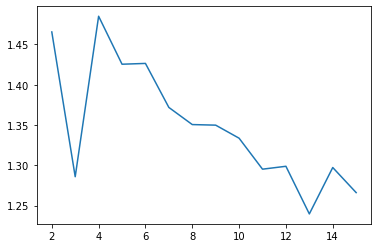

In [8]:
Db_K=[]
for i in trange(2,16) :
    nb_clusters = i
    kmeans_K = KMeans(init="k-means++", n_clusters=nb_clusters, max_iter=500, random_state=45).fit(data_K_db)
    kmeans_labels_K = kmeans_K.labels_
    db_index = davies_bouldin_score(data_K_db, kmeans_labels_K)
    Db_K.append(db_index)
    print(f"db index for Kharif with k = {nb_clusters} : ", db_index)
plt.plot(np.arange(2,16), Db_K)

In [8]:
nb_clusters_R = 7
kmeans_R = KMeans(init="k-means++", n_clusters=nb_clusters_R, max_iter=500, random_state=45).fit(data_R_db)
kmeans_labels_R = kmeans_R.labels_
db_index = davies_bouldin_score(data_R_db, kmeans_labels_R)
print(f"db index for Rabi with k = {nb_clusters_R} : ", db_index)

nb_clusters_K = 13
kmeans_K = KMeans(init="k-means++", n_clusters=nb_clusters_K, max_iter=500, random_state=45).fit(data_K_db)
kmeans_labels_K = kmeans_K.labels_
db_index = davies_bouldin_score(data_K_db, kmeans_labels_K)
print(f"db index for Rabi with k = {nb_clusters_K} : ", db_index)

db index for Rabi with k = 7 :  1.2816571762436146
db index for Rabi with k = 13 :  1.2396080143365629


In [19]:
#sauvegarder les labels optimaux 
labels_R = pd.DataFrame(kmeans_labels_R)
databis_R=df_R.reset_index()
labels_R=pd.concat((databis_R['key'],labels_R),axis=1).set_index('key')
labels_R.to_csv("../../Outputs/kmeans_labels_Rabi_26-02")

labels_K = pd.DataFrame(kmeans_labels_K)
databis_K=df_K.reset_index()
labels_K=pd.concat((databis_K['key'],labels_K),axis=1).set_index('key')
labels_K.to_csv("../../Outputs/kmeans_labels_Kharif_26-02")

### Interprétation clusters

In [20]:
labels_R = pd.DataFrame(kmeans_labels_R)
# labels_R = pd.read_csv("../../Outputs/Predictions/kmeans_labels_Rabi_14-02").drop(columns = ['key'])
databis_R=df_R.reset_index()
labeledData_R = pd.concat((databis_R,labels_R),axis=1)
labeledData_R = labeledData_R.rename({'0':'Label'},axis=1)
labeledData_R=labeledData_R.set_index(labeledData_R['key']).drop(columns = ['key'])
labeledData_R = regroupe_crop(labeledData_R)

labels_K = pd.DataFrame(kmeans_labels_K)
# labels_K = pd.read_csv("../../Outputs\Predictions\kmeans_labels_Kharif_14-02").drop(columns = ['key'])
databis_K=df_K.reset_index()
labeledData_K = pd.concat((databis_K,labels_K),axis=1)
labeledData_K = labeledData_K.rename({'0':'Label'},axis=1)
labeledData_K=labeledData_K.set_index(labeledData_K['key']).drop(columns = ['key'])
labeledData_K = regroupe_crop(labeledData_K)
labeledData_K.head()

,Crop,Area Sown (Ha),Area Insured (Ha),SI Per Ha (Inr/Ha),Lp_2011,Lp_2012,Lp_2013,Lp_2014,Lp_2015,Lp_2016,Lp_2017,Loss,0
key,,,,,,,,,,,,,
andhra pradesh_anantapur_agali__agali,Arhar,216.609811,0.168514,28750.0,0.843602,0.804674,0.874302,0.470271,0.840183,0.822226,0.0,14230.814316,6
andhra pradesh_anantapur_agali__akkagaladevarahalli,Arhar,216.609811,0.168514,28750.0,0.842151,0.802861,0.894883,0.579534,0.782517,0.820577,0.0,14464.016467,6
andhra pradesh_anantapur_agali__hulikeradevarahalli,Arhar,216.609811,0.168514,28750.0,0.843602,0.804674,0.879689,0.470271,0.840183,0.822226,0.0,14230.814316,6
andhra pradesh_anantapur_agali__inagalore,Arhar,216.609811,0.168514,28750.0,0.842151,0.802861,0.887634,0.579534,0.782517,0.820577,0.0,14464.016467,6
andhra pradesh_anantapur_agali__kodihalli,Arhar,216.609811,0.168514,28750.0,0.843602,0.804674,0.874302,0.470271,0.840183,0.822226,0.0,14230.814316,6


In [13]:
from pandas.plotting import parallel_coordinates
palette = sns.color_palette("bright", 10)

def display_parallel_coordinates(df, num_clusters):
    '''Display a parallel coordinates plot for the clusters in df'''

    # Select data points for individual clusters
    cluster_points = []
    for i in range(num_clusters):
        cluster_points.append(df[df.cluster==i])
    
    # Create the plot
    fig = plt.figure(figsize=(12, 15))
    title = fig.suptitle("Parallel Coordinates Plot for the Clusters", fontsize=18)
    fig.subplots_adjust(top=0.95, wspace=0)

    # Display one plot for each cluster, with the lines for the main cluster appearing over the lines for the other clusters
    for i in range(num_clusters):    
        plt.subplot(num_clusters, 1, i+1)
        for j,c in enumerate(cluster_points): 
            if i!= j:
                pc = parallel_coordinates(c, 'cluster', color=[addAlpha(palette[j],0.2)])
        pc = parallel_coordinates(cluster_points[i], 'cluster', color=[addAlpha(palette[i],0.5)])

        # Stagger the axes
        ax=plt.gca()
        for tick in ax.xaxis.get_major_ticks()[1::2]:
            tick.set_pad(20)        


def display_parallel_coordinates_centroids(df, num_clusters):
    '''Display a parallel coordinates plot for the centroids in df'''

    # Create the plot
    fig = plt.figure(figsize=(12, 5))
    title = fig.suptitle("Parallel Coordinates plot for the Centroids", fontsize=18)
    fig.subplots_adjust(top=0.9, wspace=0)

    # Draw the chart
    parallel_coordinates(df, 'cluster', color=palette)

    # Stagger the axes
    ax=plt.gca()
    for tick in ax.xaxis.get_major_ticks()[1::2]:
        tick.set_pad(20)    

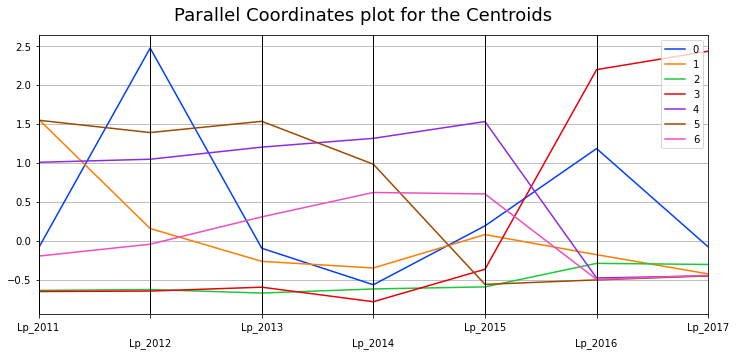

In [15]:
# Create a data frame containing our centroids
centroids = pd.DataFrame(kmeans_R.cluster_centers_, columns=data_R_db.columns)
centroids['cluster'] = centroids.index

display_parallel_coordinates_centroids(centroids, 7)

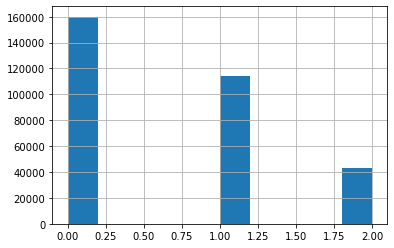

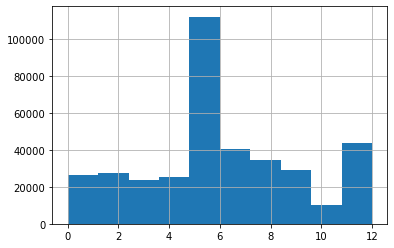

In [18]:
labeledData_R['Label'].hist()
plt.show()
labeledData_K['Label'].hist()
plt.show()


RABI


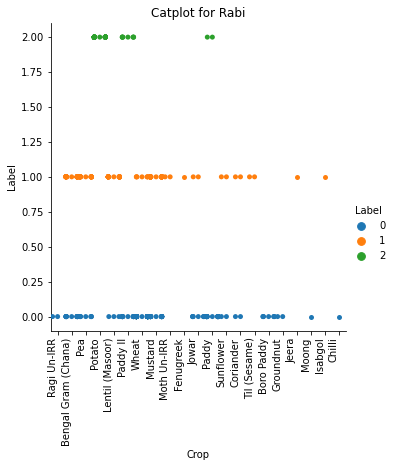

KHARIF


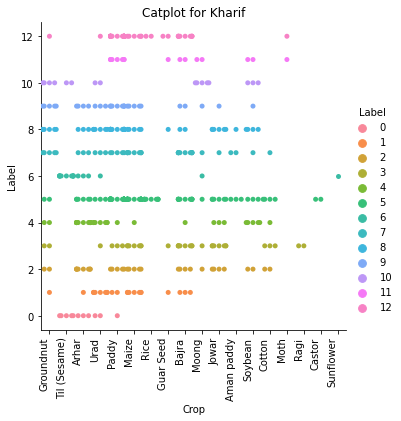

In [39]:
print("RABI")
labeledData_R.columns
sns.catplot(x='Crop', y='Label', kind="swarm", hue='Label', data=labeledData_R.sample(frac=1, random_state=0)[:500]) #sample is use to shuffle the rows of the dataset
plt.xticks(rotation=90, ha='right')
plt.title('Catplot for Rabi')
plt.show()

print("KHARIF")
labeledData_K.columns
sns.catplot(x='Crop', y='Label', kind="swarm", hue='Label', data=labeledData_K.sample(frac=1, random_state=0)[:500]) #sample is use to shuffle the rows of the dataset
plt.xticks(rotation=90, ha='right')
plt.title('Catplot for Kharif')
plt.show()

In [12]:
print("pca for Rabi")
pca_R = PCA(n_components=2,
     n_iter=10,
     copy=True,
     check_input=True,
     engine='sklearn',       ## Can be "auto", 'sklearn', 'fbpca'
     random_state=42).fit(data_R_db)
pca_data_R=pca_R.row_coordinates(data_R_db)

print("pca for Kharif")
pca_K = PCA(n_components=2,
     n_iter=10,
     copy=True,
     check_input=True,
     engine='sklearn',       ## Can be "auto", 'sklearn', 'fbpca'
     random_state=42).fit(data_K_db)
pca_data_K=pca_K.row_coordinates(data_K_db)

pca for Rabi
pca for Kharif


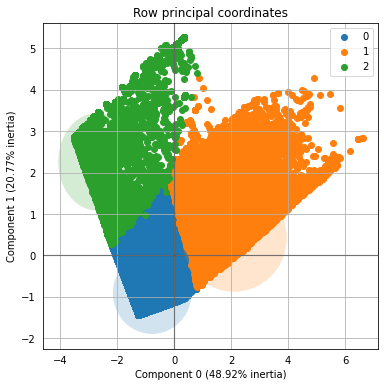

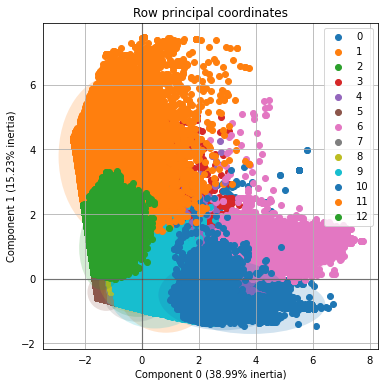

In [13]:
ax_R = pca_R.plot_row_coordinates(data_R_db, ax=None, figsize=(6, 6), x_component=0, y_component=1,
labels=None, color_labels=kmeans_labels_R, 
ellipse_outline=False, ellipse_fill=True, show_points=True)

ax_K = pca_K.plot_row_coordinates(data_K_db, ax=None, figsize=(6, 6), x_component=0, y_component=1,
labels=None, color_labels=kmeans_labels_K, 
ellipse_outline=False, ellipse_fill=True, show_points=True)

In [21]:
from sklearn.manifold import TSNE
import plotly.express as px

nb_samples = 3000
data_test = data_R_db
labels = pd.DataFrame(labels_R)

data_test  = data_test.reset_index()
data_test  = pd.concat((data_test,labels),axis=1)
data_test  = data_test.rename({'0':'Label'},axis=1)
data_test =data_test.set_index(data_test['key']).drop(columns = ['key'])
data_test = data_test.sample(frac=1, random_state=0)[:nb_samples]

In [22]:
tsne = TSNE(n_components=2, random_state=0)
projections = tsne.fit_transform(data_test.drop(columns=["Label"]))
fig = px.scatter(
    projections, x=0, y=1,
    color=data_test.Label.astype(str), labels={'color': 'Label'}
)
fig.show()

In [23]:
tsne = TSNE(n_components=3, random_state=0)
projections = tsne.fit_transform(data_test.drop(columns=["Label"]))
fig = px.scatter_3d(
    projections, x=0, y=1, z=2,
    color=data_test.Label.astype(str), labels={'color': 'Label'}
)
fig.update_traces(marker_size=8)
fig.show()

## K-means (with dummy variables + prepoccesing)

In [2]:
# # #One-Hot-Encoding
# Data_R = pd.get_dummies(df_R)
# Data_K = pd.get_dummies(df_K)

# #WITH PowerTransformer
# #Pre-processing
# for c in tqdm(Data_R.columns):
#     pt = PowerTransformer()
#     Data_R.loc[:, c] = pt.fit_transform(np.array(Data_R[c]).reshape(-1, 1))
# # Data_R.to_csv("Outputs/data_preprocessedKmeans_Rabi")

# for c in tqdm(Data_K.columns):
#     pt = PowerTransformer()
#     Data_K.loc[:, c] = pt.fit_transform(np.array(Data_K[c]).reshape(-1, 1))
# # Data_K.to_csv("Outputs/data_preprocessedKmeans_Kharif")

# #or load
Data_R=pd.read_csv("..\..\Outputs\Embeddings and preprocessed data\data_preprocessedKmeans_Rabi") #Carreful : Data with a big D here
Data_R=Data_R.set_index("key")
Data_K=pd.read_csv("..\..\Outputs\Embeddings and preprocessed data\data_preprocessedKmeans_Kharif") #Carreful : Data with a big D here
Data_K=Data_K.set_index("key")

Data_R.head()

,Area Sown (Ha),Area Insured (Ha),SI Per Ha (Inr/Ha),Lp_2011,Lp_2012,Lp_2013,Lp_2014,Lp_2015,Lp_2016,Lp_2017,...,Crop_Sunflower IRR,Crop_Sunflower Un-IRR,Crop_Taramira,Crop_Til (Sesame),Crop_Tomato,Crop_Urad,Crop_Urad Un-IRR,Crop_Wheat,Crop_Wheat IRR,Crop_Wheat Un-IRR
key,,,,,,,,,,,,,,,,,,,,,
andhra pradesh_anantapur_vidapanakal___,0.247994,1.269655,-0.807542,-0.685663,-0.857309,-0.912135,-1.111136,1.708922,1.767282,-0.551036,...,-0.033172,-0.033832,-0.038911,-0.0271,-0.009391,-0.039033,-0.006399,-0.496067,-0.257296,-0.104627
andhra pradesh_anantapur_vajrakarur___,0.247994,1.269655,-0.807542,-0.889790,-0.857309,-0.912135,-1.111136,0.639200,-0.684515,1.950434,...,-0.033172,-0.033832,-0.038911,-0.0271,-0.009391,-0.039033,-0.006399,-0.496067,-0.257296,-0.104627
andhra pradesh_anantapur_gooty___,0.247994,1.269655,-0.807542,1.272888,-0.857309,-0.912135,-0.585239,-0.885741,1.681619,1.203925,...,-0.033172,-0.033832,-0.038911,-0.0271,-0.009391,-0.039033,-0.006399,-0.496067,-0.257296,-0.104627
andhra pradesh_anantapur_guntakal___,0.247994,1.269655,-0.807542,1.272888,-0.857309,-0.912135,-0.585239,-0.885741,1.681619,1.203925,...,-0.033172,-0.033832,-0.038911,-0.0271,-0.009391,-0.039033,-0.006399,-0.496067,-0.257296,-0.104627
andhra pradesh_anantapur_pamidi___,0.247994,1.269655,-0.807542,1.272888,-0.857309,-0.912135,-0.585239,-0.885741,1.681619,1.203925,...,-0.033172,-0.033832,-0.038911,-0.0271,-0.009391,-0.039033,-0.006399,-0.496067,-0.257296,-0.104627


In [22]:
for i in trange(3,16) : 
    nb_clusters_R = i
    kmeans_R = KMeans(init="k-means++", n_clusters=nb_clusters_R, max_iter=500, random_state=45).fit(Data_R)
    kmeans_labels_R = kmeans_R.labels_
    db_index = davies_bouldin_score(data_R_db, kmeans_labels_R)
    print(f"db index for Rabi with k = {nb_clusters_R} : ", db_index)

  0%|          | 0/13 [00:00<?, ?it/s]

db index for Rabi with k = 3 :  0.8789463131715455
db index for Rabi with k = 4 :  1.2566712101868416
db index for Rabi with k = 5 :  1.2782729113839544
db index for Rabi with k = 6 :  1.379573183155804
db index for Rabi with k = 7 :  1.2816571762436146
db index for Rabi with k = 8 :  1.3040776072129343
db index for Rabi with k = 9 :  1.2796085515533915
db index for Rabi with k = 10 :  1.2737969396311546
db index for Rabi with k = 11 :  1.2576176911273944
db index for Rabi with k = 12 :  1.2278183969366767
db index for Rabi with k = 13 :  1.1983144566216297
db index for Rabi with k = 14 :  1.212174549912619
db index for Rabi with k = 15 :  1.2403679375261845


In [23]:
for i in trange(3,16) : 
    nb_clusters_K = i
    kmeans_K = KMeans(init="k-means++", n_clusters=nb_clusters_K, max_iter=500, random_state=45).fit(Data_K)
    kmeans_labels_K = kmeans_K.labels_
    db_index = davies_bouldin_score(data_K_db, kmeans_labels_K)
    print(f"db index for Kharif with k = {nb_clusters_K} : ", db_index)

  0%|          | 0/14 [00:00<?, ?it/s]

db index for Kharif with k = 2 :  1.4655587671808596
db index for Kharif with k = 3 :  1.2857888734877883
db index for Kharif with k = 4 :  1.4850622060802277
db index for Kharif with k = 5 :  1.4254887469403474
db index for Kharif with k = 6 :  1.426480270730597
db index for Kharif with k = 7 :  1.3718302945675784
db index for Kharif with k = 8 :  1.3505520872125294
db index for Kharif with k = 9 :  1.3498275263769122
db index for Kharif with k = 10 :  1.333617605398617
db index for Kharif with k = 11 :  1.2951664133413117
db index for Kharif with k = 12 :  1.29875386261543
db index for Kharif with k = 13 :  1.2396080143365629
db index for Kharif with k = 14 :  1.297223138400382
db index for Kharif with k = 15 :  1.2660613064401403


In [8]:
#Optimal Clustering

nb_clusters_R = 3
kmeans_R = KMeans(init="k-means++", n_clusters=nb_clusters_R, max_iter=500, random_state=45).fit(Data_R)
kmeans_labels_R = kmeans_R.labels_
db_index = davies_bouldin_score(data_R_db, kmeans_labels_R)
print(f"db index for Rabi with k = {nb_clusters_R} : ", db_index)

nb_clusters_K = 2
kmeans_K = KMeans(init="k-means++", n_clusters=nb_clusters_K, max_iter=500, random_state=45).fit(Data_K)
kmeans_labels_K = kmeans_K.labels_
db_index = davies_bouldin_score(data_K_db, kmeans_labels_K)
print(f"db index for Kharif with k = {nb_clusters_K} : ", db_index)

db index for Rabi with k = 3 :  0.9352165991082932
db index for Kharif with k = 2 :  1.918451877441596


In [26]:
#sauvegarder les labels optimaux 
labels_R = pd.DataFrame(kmeans_labels_R)
databis_R=df_R.reset_index()
labels_R=pd.concat((databis_R['key'],labels_R),axis=1).set_index('key')
labels_R.to_csv("Outputs/kmeans_labels_Rabi")

labels_K = pd.DataFrame(kmeans_labels_K)
databis_K=df_K.reset_index()
labels_K=pd.concat((databis_K['key'],labels_K),axis=1).set_index('key')
labels_K.to_csv("Outputs/kmeans_labels_Kharif")

In [ ]:
# #Actual Clustering DBSCAN

# data_R = pd.get_dummies(df_R)
# data_K = pd.get_dummies(df_K)
# X = StandardScaler().fit_transform(data_R).astype('float32')

# print("begining clustering")
# nb_clusters_R = 8
# dbscan_R = DBSCAN().fit(X)
# dbscan_labels_R = dbscan_R.labels_
# db_index = davies_bouldin_score(X, dbscan_labels_R)
# print(f"db index for Rabi with k = {nb_clusters_R} : ", db_index)

# # nb_clusters_K = 12
# # kmeans_K = KMeans(init="k-means++", n_clusters=nb_clusters_K, max_iter=500, n_init=6, random_state=0).fit(data_K)
# # kmeans_labels_K = kmeans_K.labels_
# # db_index = davies_bouldin_score(data_K, kmeans_labels_K)
# # print(f"db index for Rabi with k = {nb_clusters_K} : ", db_index)

### Divers plots

In [24]:
print("pca for Rabi")
pca_R = PCA(n_components=2,
     n_iter=10,
     copy=True,
     check_input=True,
     engine='sklearn',       ## Can be "auto", 'sklearn', 'fbpca'
     random_state=42).fit(Data_R)
pca_data_R=pca_R.row_coordinates(Data_R)

print("pca for Kharif")
pca_K = PCA(n_components=2,
     n_iter=10,
     copy=True,
     check_input=True,
     engine='sklearn',       ## Can be "auto", 'sklearn', 'fbpca'
     random_state=42).fit(Data_K)
pca_data_K=pca_K.row_coordinates(Data_K)

pca for Rabi
pca for Kharif


In [25]:
pca_K.explained_inertia_
pca_R.explained_inertia_

array([0.48921792, 0.20773437])

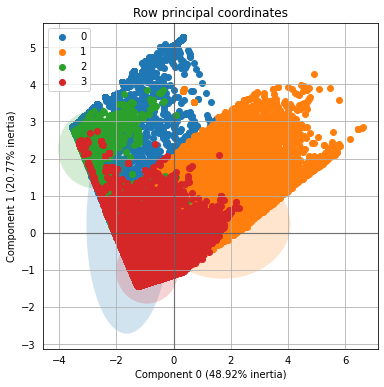

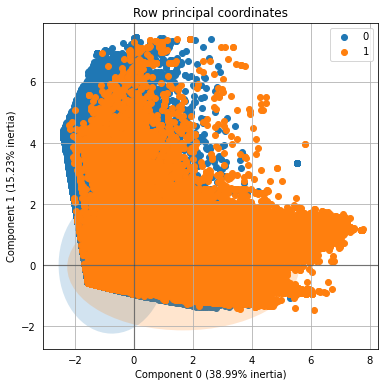

In [28]:
ax_R = pca_R.plot_row_coordinates(Data_R, ax=None, figsize=(6, 6), x_component=0, y_component=1,
labels=None, color_labels=kmeans_labels_R, 
ellipse_outline=False, ellipse_fill=True, show_points=True)

ax_K = pca_K.plot_row_coordinates(Data_K, ax=None, figsize=(6, 6), x_component=0, y_component=1,
labels=None, color_labels=kmeans_labels_K, 
ellipse_outline=False, ellipse_fill=True, show_points=True)

In [ ]:
#OPTIONAL: Elbow plot with inertia
#Elbow method to choose the optimal number of clusters
sse = {}
for k in tqdm(range(2, 20)):
    kmeans = KMeans(n_clusters=k, init="k-means++", n_init=4, max_iter=1000, random_state=0).fit(data_R)
    sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
fig = go.Figure(data=go.Scatter(x=list(sse.keys()), y=list(sse.values())))
fig.update_layout(title="Elbow plot for Rabi")

sse = {}
for k in tqdm(range(2, 20)):
    kmeans = KMeans(n_clusters=k, init="k-means++", n_init=4, max_iter=1000, random_state=0).fit(data_K)
    sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
fig = go.Figure(data=go.Scatter(x=list(sse.keys()), y=list(sse.values())))
fig.update_layout(title="Elbow plot for Kharif")
fig.show()

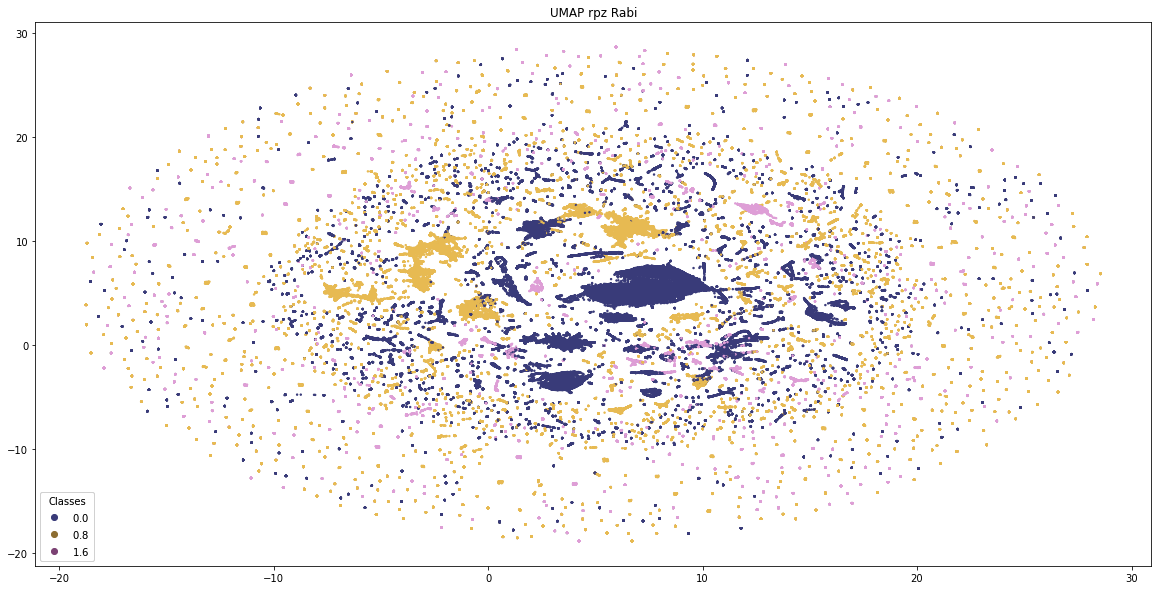

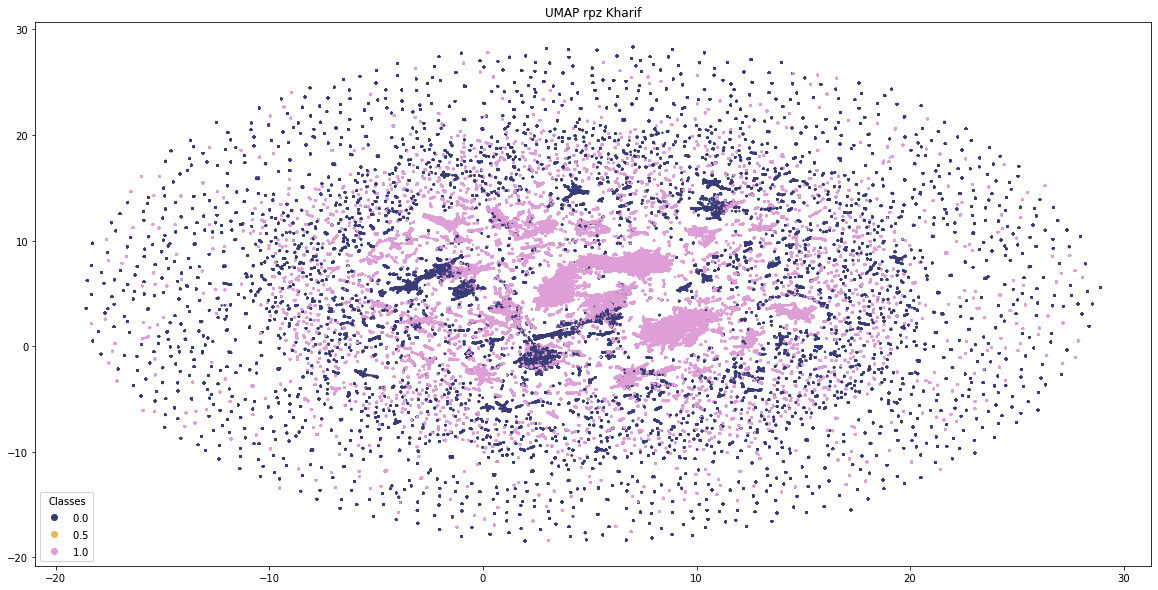

In [13]:
embedding_R = np.load(f"Outputs/embedding_Rabi.npy")
fig, ax = plt.subplots()
fig.set_size_inches((20, 10))
scatter = ax.scatter(embedding_R[:, 0], embedding_R[:, 1], s=2, c=kmeans_labels_R, cmap='tab20b', alpha=1.0)
# produce a legend with the unique colors from the scatter
legend1 = ax.legend(*scatter.legend_elements(num=nb_clusters_R),
                    loc="lower left", title="Classes")
ax.add_artist(legend1)
plt.title("UMAP rpz Rabi")
plt.show()

embedding_K = np.load(f"Outputs/embedding_Kharif.npy")
fig, ax = plt.subplots()
fig.set_size_inches((20, 10))
scatter = ax.scatter(embedding_K[:, 0], embedding_K[:, 1], s=2, c=kmeans_labels_K, cmap='tab20b', alpha=1.0)
# produce a legend with the unique colors from the scatter
legend1 = ax.legend(*scatter.legend_elements(num=nb_clusters_K),
                    loc="lower left", title="Classes")
ax.add_artist(legend1)
plt.title("UMAP rpz Kharif")
plt.show()

In [ ]:
labels_R = pd.DataFrame(kmeans_labels_R)
databis_R=df_R.reset_index()
labeledData_R = pd.concat((databis_R,labels_R),axis=1)
labeledData_R = labeledData_R.rename({0:'labels'},axis=1)
labeledData_R=labeledData_R.set_index(labeledData_R['key']).drop(columns = ['key'])

labels_K = pd.DataFrame(kmeans_labels_K)
databis_K=df_K.reset_index()
labeledData_K = pd.concat((databis_K,labels_K),axis=1)
labeledData_K = labeledData_K.rename({0:'labels'},axis=1)
labeledData_K=labeledData_K.set_index(labeledData_K['key']).drop(columns = ['key'])
labeledData_K.head()

,Crop,Area Sown (Ha),Area Insured (Ha),SI Per Ha (Inr/Ha),Sum Insured (Inr),Indemnity Level,2002 Yield,2003 Yield,2004 Yield,2005 Yield,...,2010 Yield,2011 Yield,2012 Yield,2013 Yield,2014 Yield,2015 Yield,2016 Yield,2017 Yield,Loss,labels
key,,,,,,,,,,,,,,,,,,,,,
andhra pradesh_anantapur_agali__agali,Arhar,216.609811,0.168514,28750.0,4844.772967,0.8,1096.14211,1343.496017,1231.68725,1372.571508,...,150.820333,87.096222,108.775,70.0,295.0,89.0,99.0,2888.776861,14230.814316,7
andhra pradesh_anantapur_agali__akkagaladevarahalli,Arhar,216.609811,0.168514,28750.0,4844.772967,0.8,1096.14211,1343.496017,1231.68725,1372.571508,...,150.820333,87.096222,108.775,58.0,232.0,120.0,99.0,2888.776861,14464.016467,7
andhra pradesh_anantapur_agali__hulikeradevarahalli,Arhar,216.609811,0.168514,28750.0,4844.772967,0.8,1096.14211,1343.496017,1231.68725,1372.571508,...,150.820333,87.096222,108.775,67.0,295.0,89.0,99.0,2888.776861,14230.814316,7
andhra pradesh_anantapur_agali__inagalore,Arhar,216.609811,0.168514,28750.0,4844.772967,0.8,1096.14211,1343.496017,1231.68725,1372.571508,...,150.820333,87.096222,108.775,62.0,232.0,120.0,99.0,2888.776861,14464.016467,7
andhra pradesh_anantapur_agali__kodihalli,Arhar,216.609811,0.168514,28750.0,4844.772967,0.8,1096.14211,1343.496017,1231.68725,1372.571508,...,150.820333,87.096222,108.775,70.0,295.0,89.0,99.0,2888.776861,14230.814316,7


RABI


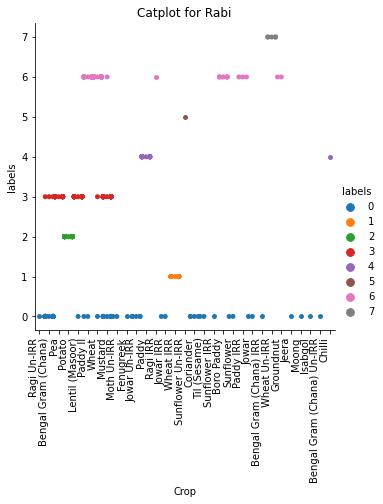

  0%|          | 0/4 [00:00<?, ?it/s]

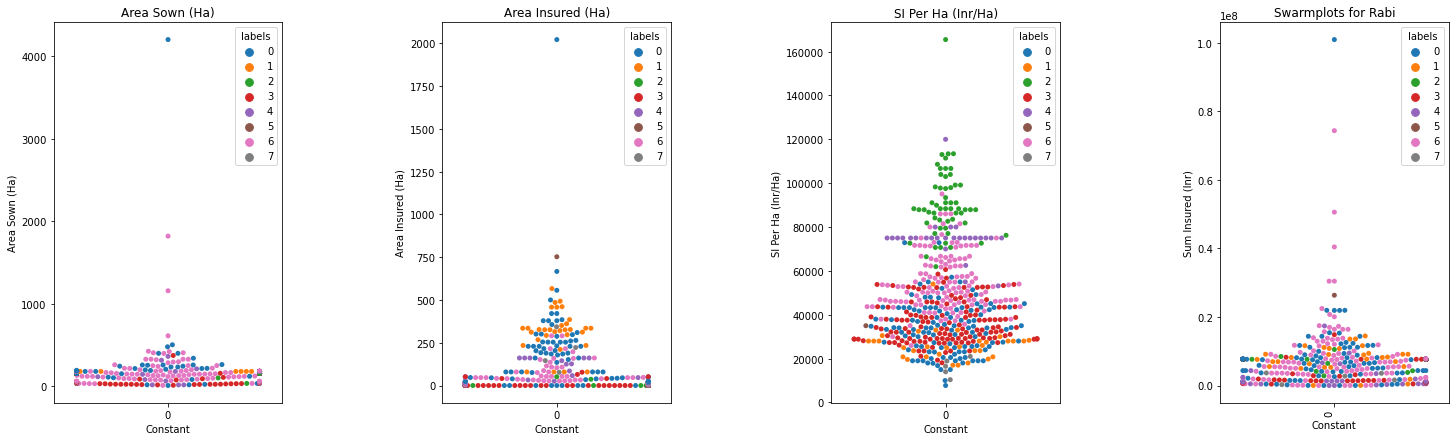

KHARIF


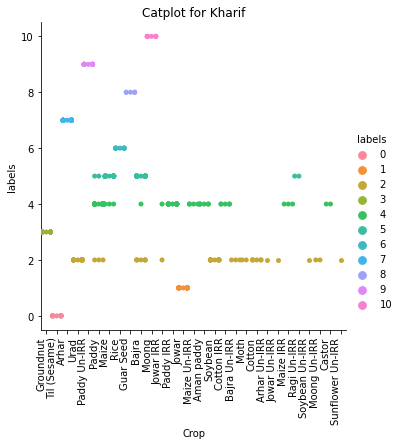

  0%|          | 0/4 [00:00<?, ?it/s]

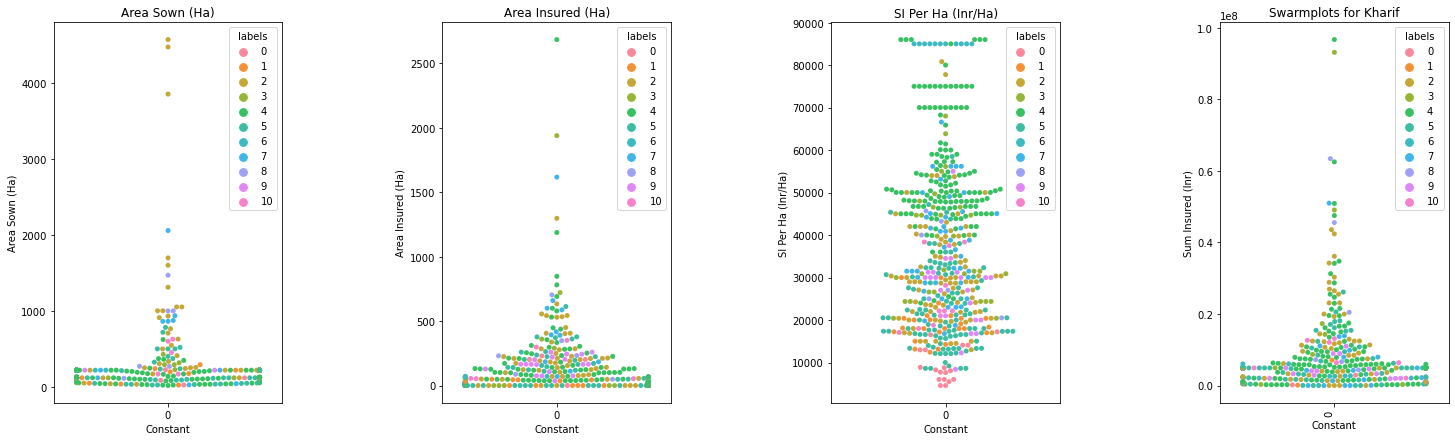

In [ ]:
#RABI
print("RABI")
labeledData_R.columns
sns.catplot(x='Crop', y='labels', kind="swarm", hue='labels', data=labeledData_R.sample(frac=1, random_state=0)[:500]) #sample is use to shuffle the rows of the dataset
plt.xticks(rotation=90, ha='right')
plt.title('Catplot for Rabi')
plt.show()
labeledData_R['Constant'] = 0 #dummy feature for plotting
f, axes = plt.subplots(1, 4, figsize=(25, 7), sharex=False)
f.subplots_adjust(hspace=0.2, wspace=0.7)
for i in trange(1,5):
    col = labeledData_R.columns[i]
    ax = sns.swarmplot(x='Constant',y=col,hue='labels',data=labeledData_R.sample(frac=1, random_state=0)[:500],ax=axes[i-1])
    plt.xticks(rotation=90, ha='right')
    ax.set_title(col)
plt.title('Swarmplots for Rabi')
plt.show()

#KHARIF
print("KHARIF")
labeledData_K.columns
sns.catplot(x='Crop', y='labels', kind="swarm", hue='labels', data=labeledData_K.sample(frac=1, random_state=0)[:500]) #sample is use to shuffle the rows of the dataset
plt.xticks(rotation=90, ha='right')
plt.title('Catplot for Kharif')
plt.show()
labeledData_K['Constant'] = 0 #dummy feature for plotting
f, axes = plt.subplots(1, 4, figsize=(25, 7), sharex=False)
f.subplots_adjust(hspace=0.2, wspace=0.7)
for i in trange(1,5):
    col = labeledData_K.columns[i]
    ax = sns.swarmplot(x='Constant',y=col,hue='labels',data=labeledData_K.sample(frac=1, random_state=0)[:500],ax=axes[i-1])
    plt.xticks(rotation=90, ha='right')
    ax.set_title(col)
plt.title('Swarmplots for Kharif')
plt.show()

### Critère DB clusters kmeans

db_index=  2.260279913121926 ,  k = 5
db_index=  2.009046116792845 ,  k = 6
db_index=  1.7727066119292147 ,  k = 7
db_index=  2.043694472486651 ,  k = 8
db_index=  1.6705098312329874 ,  k = 9
db_index=  1.797036105611864 ,  k = 10


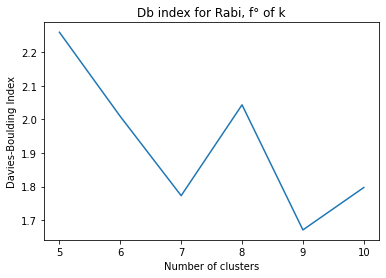

db_index=  2.694830493113122 ,  k = 5
db_index=  2.6156396710450647 ,  k = 6
db_index=  2.338091946425045 ,  k = 7
db_index=  2.150293215302705 ,  k = 8
db_index=  2.15209813685801 ,  k = 9
db_index=  1.9801691819385163 ,  k = 10


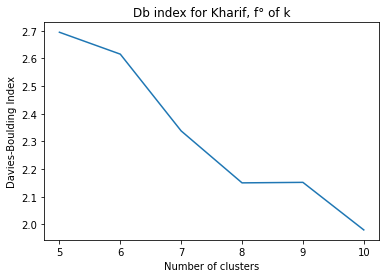

In [11]:
#RABI
results = {}
for i in range(5,11):
    kmeans = KMeans(n_clusters=i, init="k-means++", max_iter=500, n_init=10, random_state=45).fit(data_R)
    labels = kmeans.labels_
    db_index = davies_bouldin_score(data_R_db, labels)
    print("db_index= ", db_index, ",  k =", i)
    results.update({i: db_index})
plt.plot(list(results.keys()), list(results.values()))
plt.xlabel("Number of clusters")
plt.ylabel("Davies-Boulding Index")
plt.title("Db index for Rabi, f° of k")
plt.show()

#KHARIF
results = {}
for i in range(5,11):
    kmeans = KMeans(n_clusters=i, init="k-means++", max_iter=500, n_init=10, random_state=45).fit(data_K)
    labels = kmeans.labels_
    db_index = davies_bouldin_score(data_K_db, labels)
    print("db_index= ", db_index, ",  k =", i)
    results.update({i: db_index})
plt.plot(list(results.keys()), list(results.values()))
plt.xlabel("Number of clusters")
plt.ylabel("Davies-Boulding Index")
plt.title("Db index for Kharif, f° of k")
plt.show()

#### Otptimal k :

for Rabi : 8 ou 14
for Kharif : décroissant

à retester

## FAMD + Kmeans

In [13]:
print("famd for Rabi")
famd_R = FAMD(n_components=10,
     n_iter=10,
     copy=True,
     check_input=True,
     engine='sklearn',       ## Can be "auto", 'sklearn', 'fbpca'
     random_state=42).fit(data_R)
famd_data_R=famd_R.row_coordinates(data_R)

print("famd for Kharif")
famd_K = FAMD(n_components=10,
     n_iter=10,
     copy=True,
     check_input=True,
     engine='sklearn',       ## Can be "auto", 'sklearn', 'fbpca'
     random_state=42).fit(data_K)
famd_data_K=famd_K.row_coordinates(data_K)


famd_data_R.head()

famd for Rabi
famd for Kharif


,0,1,2,3,4,5,6,7,8,9
key,,,,,,,,,,
andhra pradesh_anantapur_vidapanakal___,0.523994,0.383024,-0.447408,1.463224,-0.170165,0.867293,0.240252,-0.349951,0.329677,0.167908
andhra pradesh_anantapur_vajrakarur___,0.369739,0.078710,-0.465934,1.473466,-0.201386,0.900909,0.173747,-0.251967,0.357506,0.159790
andhra pradesh_anantapur_gooty___,0.453823,0.266500,-0.394311,1.497305,-0.174836,0.891650,0.207212,-0.276235,0.337511,0.181746
andhra pradesh_anantapur_guntakal___,0.453823,0.266500,-0.394311,1.497305,-0.174836,0.891650,0.207212,-0.276235,0.337511,0.181746
andhra pradesh_anantapur_pamidi___,0.453823,0.266500,-0.394311,1.497305,-0.174836,0.891650,0.207212,-0.276235,0.337511,0.181746


In [14]:
# famd.explained_inertia_ratio_
# famd.total_inertia_
# famd.eigenvalues_
famd_R.explained_inertia_

array([0.03351968, 0.02368709, 0.0183118 , 0.01812601, 0.01790769,
       0.01782079, 0.01757603, 0.01749413, 0.01738415, 0.01735467])

In [12]:
for i in trange(3,16) : 
    nb_clusters_R = i
    kmeans_R = KMeans(init="k-means++", n_clusters=nb_clusters_R, max_iter=500, random_state=45).fit(famd_data_R)
    kmeans_labels_R = kmeans_R.labels_
    db_index = davies_bouldin_score(data_R_db, kmeans_labels_R)
    print(f"db index for Rabi with k = {nb_clusters_R} : ", db_index)

  0%|          | 0/13 [00:00<?, ?it/s]

db index for Rabi with k = 3 :  0.9986599668032672
db index for Rabi with k = 4 :  4.561125969613828
db index for Rabi with k = 5 :  4.16289499771964
db index for Rabi with k = 6 :  3.5726351471658515
db index for Rabi with k = 7 :  4.02934307252346
db index for Rabi with k = 8 :  3.821150048459352
db index for Rabi with k = 9 :  3.8450230293325043
db index for Rabi with k = 10 :  5.415563270047821
db index for Rabi with k = 11 :  5.0375227795485555
db index for Rabi with k = 12 :  4.9917171632975705
db index for Rabi with k = 13 :  4.785474667232218
db index for Rabi with k = 14 :  4.655828981573096
db index for Rabi with k = 15 :  5.326573250405052


In [13]:
for i in trange(3,16) : 
    nb_clusters_K = i
    kmeans_K = KMeans(init="k-means++", n_clusters=nb_clusters_K, max_iter=500, random_state=45).fit(famd_data_K)
    kmeans_labels_K = kmeans_K.labels_
    db_index = davies_bouldin_score(data_K_db, kmeans_labels_K)
    print(f"db index for Kharif with k = {nb_clusters_K} : ", db_index)

  0%|          | 0/13 [00:00<?, ?it/s]

db index for Kharif with k = 3 :  4.4009871247104355
db index for Kharif with k = 4 :  3.436553073217695
db index for Kharif with k = 5 :  4.63738843535975
db index for Kharif with k = 6 :  5.17037368017094
db index for Kharif with k = 7 :  5.487964359139377
db index for Kharif with k = 8 :  4.18025690674532
db index for Kharif with k = 9 :  5.808043358253722
db index for Kharif with k = 10 :  5.353876156877901
db index for Kharif with k = 11 :  5.247923107433536
db index for Kharif with k = 12 :  5.0905356074519785
db index for Kharif with k = 13 :  5.756677969312784
db index for Kharif with k = 14 :  4.831001734837521
db index for Kharif with k = 15 :  4.909435754414448


In [15]:
#Optimal Clustering

nb_clusters_R = 3
kmeans_R = KMeans(init="k-means++", n_clusters=nb_clusters_R, max_iter=500, random_state=45).fit(famd_data_R)
kmeans_labels_R = kmeans_R.labels_
db_index = davies_bouldin_score(data_R_db, kmeans_labels_R)
print(f"db index for Rabi with k = {nb_clusters_R} : ", db_index)

nb_clusters_K = 2
kmeans_K = KMeans(init="k-means++", n_clusters=nb_clusters_K, max_iter=500, random_state=45).fit(famd_data_K)
kmeans_labels_K = kmeans_K.labels_
db_index = davies_bouldin_score(data_K_db, kmeans_labels_K)
print(f"db index for Kharif with k = {nb_clusters_K} : ", db_index)

db index for Rabi with k = 3 :  0.9986599668032672
db index for Kharif with k = 2 :  1.8941597228332907


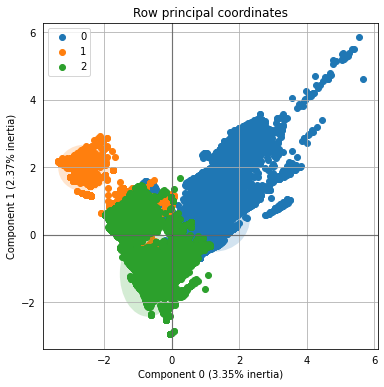

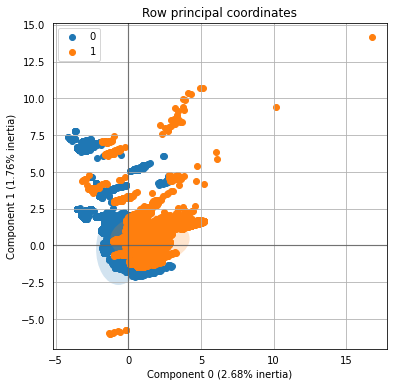

In [16]:
ax_R = famd_R.plot_row_coordinates(data_R, ax=None, figsize=(6, 6), x_component=0, y_component=1,
labels=None, color_labels=kmeans_labels_R, 
ellipse_outline=False, ellipse_fill=True, show_points=True)

ax_K = famd_K.plot_row_coordinates(data_K, ax=None, figsize=(6, 6), x_component=0, y_component=1,
labels=None, color_labels=kmeans_labels_K, 
ellipse_outline=False, ellipse_fill=True, show_points=True)
#OR
# embedding_R = np.array(famd_data_R)
# fig, ax = plt.subplots()
# fig.set_size_inches((20, 10))
# scatter = ax.scatter(embedding_R[:, 0], embedding_R[:, 1], s=2, c=pred, cmap='tab20b', alpha=1.0)
# # produce a legend with the unique colors from the scatter
# legend1 = ax.legend(*scatter.legend_elements(num=nb_clusters_R),
#                     loc="lower left", title="Classes")
# ax.add_artist(legend1)
# plt.title("FAMD rpz Rabi")
# plt.show()

In [ ]:
# from utils import plot_on_map
# plot_on_map(pred, pathData_R, 'District')

# Approches sans succès

## UMAP embeding

In [7]:
#Preprocessing numerical

numerical = df_R.select_dtypes(exclude='object')

for c in numerical.columns:
    pt = PowerTransformer()
    numerical.loc[:, c] = pt.fit_transform(np.array(numerical[c]).reshape(-1, 1))
    
##preprocessing categorical
categorical = df_R.select_dtypes(include='object')
categorical = pd.get_dummies(categorical)

#Percentage of columns which are categorical is used as weight parameter in embeddings later
categorical_weight = len(df_R.select_dtypes(include='object').columns) / df_R.shape[1]

In [8]:
fit1 = umap.UMAP(metric='l2').fit(numerical)
fit2 = umap.UMAP(metric='dice').fit(categorical)

In [11]:
import umap.umap_ as uu

# #Augmenting the numerical embedding with categorical
intersection = uu.general_simplicial_set_intersection(fit1.graph_, fit2.graph_, weight=categorical_weight)
intersection = uu.reset_local_connectivity(intersection)
embedding = uu.simplicial_set_embedding(fit1._raw_data, intersection, fit1.n_components, 
                                                fit1._initial_alpha, fit1._a, fit1._b, 
                                                fit1.repulsion_strength, fit1.negative_sample_rate, 
                                                200, 'random', np.random, fit1.metric, 
                                                fit1._metric_kwds, False, densmap_kwds="Salut", output_dens=False)

embedding=embedding[0]
np.save("../../Outputs/Embeddings and preprocessed data/UMAP_27-01_embedding_Rabi",embedding)  

In [21]:
embedding=np.load("../../Outputs/Embeddings and preprocessed data/UMAP_27-01_embedding_Rabi.npy")

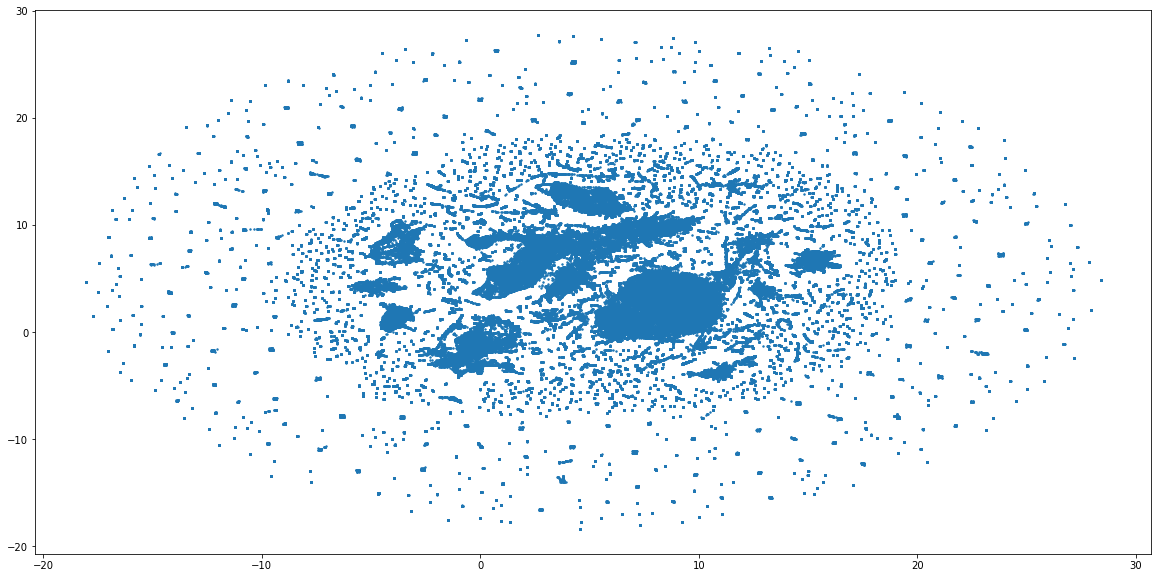

In [22]:
plt.figure(figsize=(20, 10))
plt.scatter(*embedding.T, s=2, cmap='Spectral', alpha=1.0)
plt.show()

In [21]:
embedding.T.shape

(2, 317503)

In [23]:
for i in trange(3,16) : 
    nb_clusters_R = i
    kmeans_R = KMeans(init="k-means++", n_clusters=nb_clusters_R, max_iter=500, random_state=45).fit(embedding)
    kmeans_labels_R = kmeans_R.labels_
    db_index = davies_bouldin_score(data_R_db, kmeans_labels_R)
    print(f"db index for Rabi with k = {nb_clusters_R} : ", db_index)

  0%|          | 0/13 [00:00<?, ?it/s]

db index for Rabi with k = 3 :  11.996294034818701
db index for Rabi with k = 4 :  10.31812471721688
db index for Rabi with k = 5 :  12.816217787619525
db index for Rabi with k = 6 :  19.335466241376917
db index for Rabi with k = 7 :  13.309429089846832
db index for Rabi with k = 8 :  15.614083561193258
db index for Rabi with k = 9 :  16.148144965229605
db index for Rabi with k = 10 :  16.015772493764583
db index for Rabi with k = 11 :  13.602086413489504
db index for Rabi with k = 12 :  17.698529485914086
db index for Rabi with k = 13 :  15.17209426702713
db index for Rabi with k = 14 :  14.673054777253629
db index for Rabi with k = 15 :  12.889418474777766


In [18]:
nb_clusters_R = 4
kmeans_R = KMeans(init="k-means++", n_clusters=nb_clusters_R, max_iter=500, random_state=45).fit(Data_R) #embedding
kmeans_labels_R = kmeans_R.labels_
db_index = davies_bouldin_score(data_R_db, kmeans_labels_R)
print(f"db index for Rabi with k = {nb_clusters_R} : ", db_index)

db index for Rabi with k = 4 :  1.493048160419026


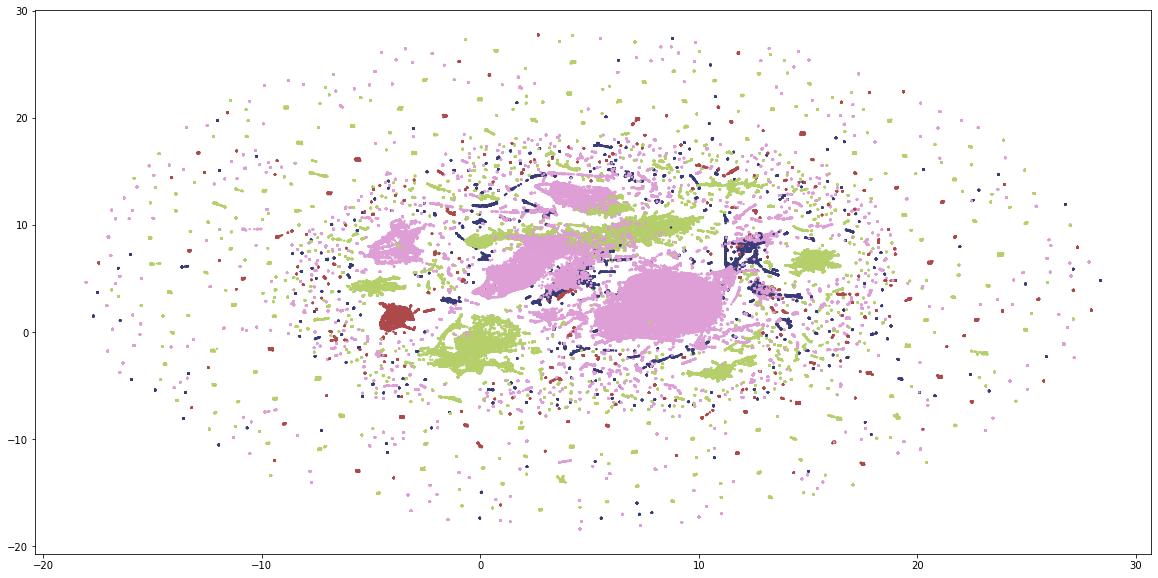

In [23]:
plt.figure(figsize=(20, 10))
plt.scatter(embedding[:, 0], embedding[:, 1], s=2, c=kmeans_labels_R, cmap='tab20b', alpha=1.0)
plt.show()

## K-Prototypes

In [5]:
kprot_data_R = df_R.copy(deep=True)
kprot_data_K = df_K.copy(deep=True)

#Pre-processing
for c in tqdm(df_R.select_dtypes(exclude='object').columns):
    pt = PowerTransformer()
    kprot_data_R[c] =  pt.fit_transform(np.array(kprot_data_R[c]).reshape(-1, 1))

  0%|          | 0/22 [00:00<?, ?it/s]

In [ ]:
categorical_columns = [0] #make sure to specify correct indices

#Actual clustering
nb_clusters_R=10
kproto_R = KPrototypes(n_clusters= nb_clusters_R, init='Cao', n_jobs = os.cpu_count(), verbose = 1) #n_jobs=4
clusters_R = kproto_R.fit_predict(kprot_data_R, categorical=categorical_columns)

In [ ]:
clusters_R.to_csv("clusters_kprot_R")

In [ ]:
db_index = davies_bouldin_score(kprot_data_R, clusters_R)
print(f"db index for Rabi with k = {nb_clusters_R} : ", db_index)

In [22]:
#Prints the count of each cluster group
pd.Series(clusters).value_counts()

13    2984
2     2804
4     1988
11    1925
12    1757
3     1675
8     1526
14    1026
5      975
1      966
7      341
10     268
9      235
6      166
0       99
dtype: int64

In [23]:
# #OPTIONAL: Elbow plot with cost (will take a LONG time)
# costs = []
# n_clusters = []
# clusters_assigned = []

# for i in tqdm(range(2, 25)):
#     try:
#         kproto = KPrototypes(n_clusters= i, init='Cao', verbose=2)
#         clusters = kproto.fit_predict(kprot_data, categorical=[0, 6, 7, 9, 13])
#         costs.append(kproto.cost_)
#         n_clusters.append(i)
#         clusters_assigned.append(clusters)
#     except:
#         print(f"Can't cluster with {i} clusters")
        
# fig = go.Figure(data=go.Scatter(x=n_clusters, y=costs ))
# fig.show()

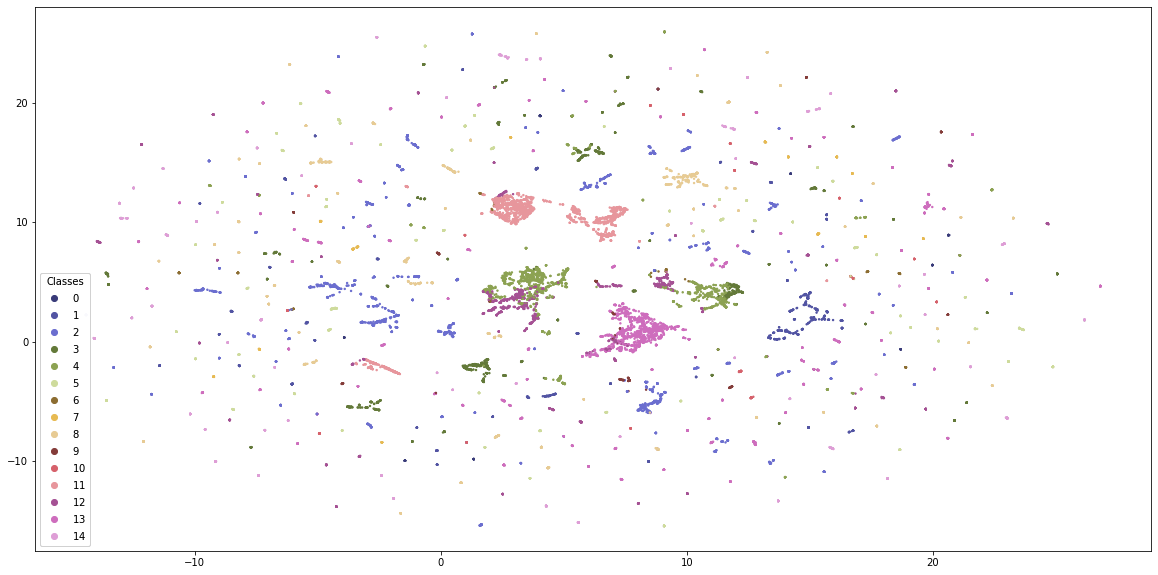

In [24]:
embedding_R = np.load(f"Outputs/embedding_Rabi.npy")

fig, ax = plt.subplots()
fig.set_size_inches((20, 10))
scatter = ax.scatter(embedding_R[:, 0], embedding_R[:, 1], s=2, c=clusters, cmap='tab20b', alpha=1.0)

# produce a legend with the unique colors from the scatter
legend1 = ax.legend(*scatter.legend_elements(num=15),
                    loc="lower left", title="Classes")
ax.add_artist(legend1)

## UMAP + Kmeans

In [4]:
#Preprocessing numerical
numerical = df_R.select_dtypes(exclude='object')

for c in numerical.columns:
    pt = PowerTransformer()
    numerical.loc[:, c] = pt.fit_transform(np.array(numerical[c]).reshape(-1, 1))
    
##preprocessing categorical
categorical = df_R.select_dtypes(include='object')
categorical = pd.get_dummies(categorical)

#Percentage of columns which are categorical is used as weight parameter in embeddings later
categorical_weight = len(df_R.select_dtypes(include='object').columns) / df_R.shape[1]

In [ ]:
fit1 = umap.UMAP(metric='l2', n_components=5).fit(numerical) #.astype('float32')
fit2 = umap.UMAP(metric='dice', n_components=5).fit(categorical)

In [ ]:
import umap.umap_ as uu

# #Augmenting the numerical embedding with categorical
intersection = uu.general_simplicial_set_intersection(fit1.graph_, fit2.graph_, weight=categorical_weight)
intersection = uu.reset_local_connectivity(intersection)
embedding_R = uu.simplicial_set_embedding(fit1._raw_data, intersection, fit1.n_components, 
                                                fit1._initial_alpha, fit1._a, fit1._b, 
                                                fit1.repulsion_strength, fit1.negative_sample_rate, 
                                                200, 'random', np.random, fit1.metric, 
                                                fit1._metric_kwds, False, densmap_kwds="Salut", output_dens=False)

In [ ]:
embedding_R=embedding_R[0]

In [ ]:
#Actual Clustering

nb_clusters_R = 8
kmeans_R = KMeans(init="k-means++", n_clusters=nb_clusters_R, max_iter=500, n_init=6, random_state=0).fit(embedding_R)
kmeans_labels_R = kmeans_R.labels_
db_index = davies_bouldin_score(data_R, kmeans_labels_R)
print(f"db index for Rabi with k = {nb_clusters_R} : ", db_index)

# nb_clusters_K = 12
# kmeans_K = KMeans(init="k-means++", n_clusters=nb_clusters_K, max_iter=500, n_init=6, random_state=0).fit(data_K)
# kmeans_labels_K = kmeans_K.labels_
# db_index = davies_bouldin_score(data_K, kmeans_labels_K)
# print(f"db index for Rabi with k = {nb_clusters_K} : ", db_index)

In [ ]:
plot